In [63]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [64]:
# 读取Excel文件
df_task = pd.read_excel('../data/Q1.xlsx')  
df_member = pd.read_excel('../data/Q2.xlsx')

In [65]:
df_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况
0,A0001,22.566142,113.980837,66.0,0
1,A0002,22.686205,113.940525,65.5,0
2,A0003,22.576512,113.957198,65.5,1
3,A0004,22.564841,114.244571,75.0,0
4,A0005,22.558888,113.950723,65.5,0
...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0
831,A0832,22.833262,113.280152,72.0,1
832,A0833,22.814676,113.827731,85.0,1
833,A0834,23.063674,113.771188,65.5,1


In [66]:
df_member

,会员编号,会员位置(GPS),预订任务限额,预订任务开始时间,信誉值
0,B0001,22.947097 113.679983,114,06:30:00,67997.3868
1,B0002,22.577792 113.966524,163,06:30:00,37926.5416
2,B0003,23.192458 113.347272,139,06:30:00,27953.0363
3,B0004,23.255965 113.31875,98,06:30:00,25085.6986
4,B0005,33.65205 116.97047,66,06:30:00,20919.0667
...,...,...,...,...,...
1872,B1873,22.840505 113.277245,1,08:00:00,0.0124
1873,B1874,23.069415 113.287606,1,08:00:00,0.0121
1874,B1875,23.333446 113.301736,1,08:00:00,0.0062
1875,B1876,22.693506 113.994101,1,08:00:00,0.0036


In [67]:
df_task['任务标价']

0      66.0
1      65.5
2      65.5
3      75.0
4      65.5
       ... 
830    65.5
831    72.0
832    85.0
833    65.5
834    85.0
Name: 任务标价, Length: 835, dtype: float64

基准值

In [68]:
min(df_task['任务标价'])

65.0

## 1、会员因素

In [69]:
import math

def euclidean_distance(lat1, lon1, lat2, lon2):
    # 将纬度和经度转换为相同单位
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    # 简单的欧几里得距离
    return math.sqrt(delta_lat ** 2 + delta_lon ** 2) * 111  # 1度大约为111公里

In [70]:
# 统计每个任务点1km内的顾客数量
result_member = []

for index, task in df_task.iterrows():
    task_lat, task_lon = task['任务gps纬度'], task['任务gps经度']
    count = 0
    score = 0
    members_within_1km = []  # 用于存储1km内的顾客信息

    # 遍历1km内的所有顾客
    for _, member in df_member.iterrows():
        member_lat, member_lon = map(float, member['会员位置(GPS)'].split())
        distance = euclidean_distance(task_lat, task_lon, member_lat, member_lon)
        
        if distance <= 1:
            count += 1
            members_within_1km.append({
                '会员ID': member['会员编号'],  # 可选，用于标识会员
                '信誉分': member['信誉值'],
                '距离': distance
            })
            # 分数累积
            score += (member['预订任务限额'] + math.sqrt(member['信誉值'])) * (1-distance) * 0.01

    result_member.append({
        '任务号码': task['任务号码'], 
        '1km内顾客数量': count,
        '顾客信息': members_within_1km,  # 存储顾客的信誉分和距离
        '该任务点的会员因子分数': score      # 该任务点的会员因子分数
    })

In [71]:
# 转换为DataFrame并显示
df_result_member = pd.DataFrame(result_member)
df_result_member

,任务号码,1km内顾客数量,顾客信息,该任务点的会员因子分数
0,A0001,0,[],0.000000
1,A0002,12,"[{'会员ID': 'B0283', '信誉分': 79.6925, '距离': 0.798...",0.259111
2,A0003,2,"[{'会员ID': 'B0354', '信誉分': 53.1584, '距离': 0.514...",0.096090
3,A0004,0,[],0.000000
4,A0005,2,"[{'会员ID': 'B0712', '信誉分': 19.9231, '距离': 0.321...",0.064608
...,...,...,...,...
830,A0831,3,"[{'会员ID': 'B0339', '信誉分': 59.7694, '距离': 0.832...",0.081730
831,A0832,1,"[{'会员ID': 'B1873', '信誉分': 0.0124, '距离': 0.8662...",0.001486
832,A0833,0,[],0.000000
833,A0834,4,"[{'会员ID': 'B0215', '信誉分': 115.5408, '距离': 0.80...",0.335116


## 2、竞争因素

In [72]:
# 统计每个任务点1km内的其他任务点数量
result_cpt = []

for index, task in df_task.iterrows():
    task_lat, task_lon = task['任务gps纬度'], task['任务gps经度']
    count = 0
    score = 0
    tasks_within_1km = []  # 用于存储1km内的顾客信息

    # 遍历1km内的所有其他任务点
    for _, oppotask in df_task.iterrows():
        oppotask_lat, oppotask_lon = oppotask['任务gps纬度'], oppotask['任务gps经度']
        distance = euclidean_distance(task_lat, task_lon, oppotask_lat, oppotask_lon)
        
        if distance <= 1 and distance != 0:
            count += 1
            tasks_within_1km.append({
                '任务号码': oppotask['任务号码'],  # 可选，用于标识会员
                '距离': distance
            })
            # 分数累积
            score += min(math.sqrt(1 / distance) * 0.1, 5)

    result_cpt.append({
        '其他任务ID': task['任务号码'], 
        '1km内其他任务点数量': count,
        '其他任务点的信息': tasks_within_1km,  # 存储顾客的信誉分和距离
        '该任务点的竞争因子分数': score      # 该任务点的竞争因子分数
    })

In [73]:
# 转换为DataFrame并显示
df_result_cpt = pd.DataFrame(result_cpt)
df_result_cpt

,其他任务ID,1km内其他任务点数量,其他任务点的信息,该任务点的竞争因子分数
0,A0001,2,"[{'任务号码': 'A0029', '距离': 0.20568449470847416},...",0.321041
1,A0002,2,"[{'任务号码': 'A0364', '距离': 0.6155373624668447}, ...",0.238261
2,A0003,1,"[{'任务号码': 'A0360', '距离': 0.6919575182975204}]",0.120215
3,A0004,1,"[{'任务号码': 'A0006', '距离': 0.7422286186792472}]",0.116073
4,A0005,1,"[{'任务号码': 'A0008', '距离': 0.7796263532124108}]",0.113255
...,...,...,...,...
830,A0831,1,"[{'任务号码': 'A0609', '距离': 0.5444309928747162}]",0.135528
831,A0832,0,[],0.000000
832,A0833,0,[],0.000000
833,A0834,2,"[{'任务号码': 'A0521', '距离': 0.9278951895677189}, ...",0.804301


训练完，得到 k、w，然后再定价

In [74]:
price = []  # 初始化价格列表
k = 5
w = 5

for i in df_task.index:  # 使用 .index 确保按索引遍历
    # 假设 df_result_member 是 DataFrame，并且 i 是任务点的标识符
    member_factor = df_result_member.loc[i, '该任务点的会员因子分数']
    competition_factor = df_result_cpt.loc[i, '该任务点的竞争因子分数']
    
    # 计算该任务点的价格
    task_price = min(65 + k * member_factor + w * competition_factor, 120) # 不能超过这个价格
    
    # 将计算的价格添加到 price 列表
    price.append(task_price)

# 如果你希望将 price 添加为 df_task 的一列，可以使用以下代码
df_task['预测合理价格'] = price
df_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格
0,A0001,22.566142,113.980837,66.0,0,66.605203
1,A0002,22.686205,113.940525,65.5,0,67.486857
2,A0003,22.576512,113.957198,65.5,1,66.081525
3,A0004,22.564841,114.244571,75.0,0,65.580365
4,A0005,22.558888,113.950723,65.5,0,65.889314
...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292
831,A0832,22.833262,113.280152,72.0,1,65.007432
832,A0833,22.814676,113.827731,85.0,1,65.000000
833,A0834,23.063674,113.771188,65.5,1,70.697085


校验定价区间合理性

In [75]:
df_task['预测合理价格'].min()

65.0

In [76]:
df_task['预测合理价格'].max()

84.59215009615079

In [77]:
df_task['预测合理价格'].mean()

66.6864803564597

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. 预处理数据
# 将会员位置(GPS)拆分为经度和纬度
df_member[['会员纬度', '会员经度']] = df_member['会员位置(GPS)'].str.split(expand=True).astype(float)

# 选择任务数据和会员数据的特征进行合并
# 例如：根据任务ID或其他关联特征合并数据
# 这里假设任务表和会员表已经预先关联好
df = pd.merge(df_task, df_member, left_on='任务gps纬度', right_on='会员纬度', how='left')

# 特征选择（可以根据你的数据进行调整）
X = df[['任务gps纬度', '任务gps经度', '任务标价', '信誉值', '预订任务限额']]
y = df['任务执行情况']  # 这是你要预测的目标变量

In [79]:
# 2. 数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 模型训练
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. 预测
y_pred = model.predict(X_test)

# 5. 模型评估
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8323353293413174
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        66
           1       0.88      0.84      0.86       101

    accuracy                           0.83       167
   macro avg       0.82      0.83      0.83       167
weighted avg       0.83      0.83      0.83       167



## 原本数据

In [80]:
df_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格
0,A0001,22.566142,113.980837,66.0,0,66.605203
1,A0002,22.686205,113.940525,65.5,0,67.486857
2,A0003,22.576512,113.957198,65.5,1,66.081525
3,A0004,22.564841,114.244571,75.0,0,65.580365
4,A0005,22.558888,113.950723,65.5,0,65.889314
...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292
831,A0832,22.833262,113.280152,72.0,1,65.007432
832,A0833,22.814676,113.827731,85.0,1,65.000000
833,A0834,23.063674,113.771188,65.5,1,70.697085


在原本任务表Q1中，加上不含k,w的那两列原始影响数据

In [81]:
# 假设 df_result_member 和 df_result_cpt 是单列的 DataFrame，且与 df_task 具有相同的索引

# 首先将会员因子分数和竞争因子分数合并到 df_task 中
df_new_task = df_task.copy()  # 复制原始任务数据

# 添加会员因子分数列
df_new_task['会员因子分数'] = df_result_member['该任务点的会员因子分数']

# 添加竞争因子分数列
df_new_task['竞争因子分数'] = df_result_cpt['该任务点的竞争因子分数']

此时 df_new_task 为加上特征后的 df，因此可以开始训练！

In [82]:
df_new_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员因子分数,竞争因子分数
0,A0001,22.566142,113.980837,66.0,0,66.605203,0.000000,0.321041
1,A0002,22.686205,113.940525,65.5,0,67.486857,0.259111,0.238261
2,A0003,22.576512,113.957198,65.5,1,66.081525,0.096090,0.120215
3,A0004,22.564841,114.244571,75.0,0,65.580365,0.000000,0.116073
4,A0005,22.558888,113.950723,65.5,0,65.889314,0.064608,0.113255
...,...,...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292,0.081730,0.135528
831,A0832,22.833262,113.280152,72.0,1,65.007432,0.001486,0.000000
832,A0833,22.814676,113.827731,85.0,1,65.000000,0.000000,0.000000
833,A0834,23.063674,113.771188,65.5,1,70.697085,0.335116,0.804301


## 预测完成率
#### 先随机森林训练

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. 准备数据
# X 是特征集，选择 '任务标价'、'会员因子分数' 和 '竞争因子分数' 列
X = df_new_task[['任务gps纬度', '任务gps经度', '任务标价', '会员因子分数', '竞争因子分数']]

# y 是目标变量，选择 '任务执行情况' 列
y = df_new_task['任务执行情况']

# 2. 数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 模型训练
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 4. 预测
y_pred = model.predict(X_test)

# 5. 模型评估
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8562874251497006
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        66
           1       0.89      0.87      0.88       101

    accuracy                           0.86       167
   macro avg       0.85      0.85      0.85       167
weighted avg       0.86      0.86      0.86       167



调参：树的棵树

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. 准备数据
X = df_new_task[['任务gps纬度', '任务gps经度', '任务标价', '会员因子分数', '竞争因子分数']]
y = df_new_task['任务执行情况']

# 2. 数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 调参
best_accuracy = 0
best_n_estimators = 0
accuracies = []

for n in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append((n, accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_estimators = n

# 输出最佳结果
print(f"Best n_estimators: {best_n_estimators} with Accuracy: {best_accuracy}")

# 打印每个 n_estimators 对应的准确率
for n, accuracy in accuracies:
    print(f"n_estimators: {n}, Accuracy: {accuracy}")

Best n_estimators: 180 with Accuracy: 0.8562874251497006
n_estimators: 10, Accuracy: 0.8143712574850299
n_estimators: 20, Accuracy: 0.8383233532934131
n_estimators: 30, Accuracy: 0.8203592814371258
n_estimators: 40, Accuracy: 0.8203592814371258
n_estimators: 50, Accuracy: 0.8263473053892215
n_estimators: 60, Accuracy: 0.8323353293413174
n_estimators: 70, Accuracy: 0.8383233532934131
n_estimators: 80, Accuracy: 0.8203592814371258
n_estimators: 90, Accuracy: 0.8383233532934131
n_estimators: 100, Accuracy: 0.8323353293413174
n_estimators: 110, Accuracy: 0.8383233532934131
n_estimators: 120, Accuracy: 0.844311377245509
n_estimators: 130, Accuracy: 0.8502994011976048
n_estimators: 140, Accuracy: 0.8502994011976048
n_estimators: 150, Accuracy: 0.844311377245509
n_estimators: 160, Accuracy: 0.8502994011976048
n_estimators: 170, Accuracy: 0.8502994011976048
n_estimators: 180, Accuracy: 0.8562874251497006
n_estimators: 190, Accuracy: 0.8562874251497006
n_estimators: 200, Accuracy: 0.85628742514

新的完成率预测

复原列名（复原个屁...，如果下面的代码出错，就执行这个代码进行复原，但是从上往下执行的话，要跳过下面这一段代码块！！！）

In [85]:
# # 获取列名列表
# columns = df_new_task.columns.to_list()

# # 获取第一个 '任务标价' 的索引位置
# first_index = columns.index('预测合理价格')

# # 重命名第一个 '任务标价' 列的名称
# df_new_task.columns.values[first_index] = '任务标价'

In [86]:
# 查看修改后的 DataFrame
df_new_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员因子分数,竞争因子分数
0,A0001,22.566142,113.980837,66.0,0,66.605203,0.000000,0.321041
1,A0002,22.686205,113.940525,65.5,0,67.486857,0.259111,0.238261
2,A0003,22.576512,113.957198,65.5,1,66.081525,0.096090,0.120215
3,A0004,22.564841,114.244571,75.0,0,65.580365,0.000000,0.116073
4,A0005,22.558888,113.950723,65.5,0,65.889314,0.064608,0.113255
...,...,...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292,0.081730,0.135528
831,A0832,22.833262,113.280152,72.0,1,65.007432,0.001486,0.000000
832,A0833,22.814676,113.827731,85.0,1,65.000000,0.000000,0.000000
833,A0834,23.063674,113.771188,65.5,1,70.697085,0.335116,0.804301


In [87]:
# 1. 准备新的特征集 X（使用 '预测合理价格' 列）
X_new = df_new_task[['任务gps纬度', '任务gps经度', '预测合理价格', '会员因子分数', '竞争因子分数']]
X_new

,任务gps纬度,任务gps经度,预测合理价格,会员因子分数,竞争因子分数
0,22.566142,113.980837,66.605203,0.000000,0.321041
1,22.686205,113.940525,67.486857,0.259111,0.238261
2,22.576512,113.957198,66.081525,0.096090,0.120215
3,22.564841,114.244571,65.580365,0.000000,0.116073
4,22.558888,113.950723,65.889314,0.064608,0.113255
...,...,...,...,...,...
830,23.044062,113.125784,66.086292,0.081730,0.135528
831,22.833262,113.280152,65.007432,0.001486,0.000000
832,22.814676,113.827731,65.000000,0.000000,0.000000
833,23.063674,113.771188,70.697085,0.335116,0.804301


In [88]:
# 将 '预测合理价格' 列重命名为 '任务标价'
X_new = X_new.rename(columns={'预测合理价格': '任务标价'})
# X_new = X_new.rename(columns={'任务标价': '预测合理价格'})
X_new

,任务gps纬度,任务gps经度,任务标价,会员因子分数,竞争因子分数
0,22.566142,113.980837,66.605203,0.000000,0.321041
1,22.686205,113.940525,67.486857,0.259111,0.238261
2,22.576512,113.957198,66.081525,0.096090,0.120215
3,22.564841,114.244571,65.580365,0.000000,0.116073
4,22.558888,113.950723,65.889314,0.064608,0.113255
...,...,...,...,...,...
830,23.044062,113.125784,66.086292,0.081730,0.135528
831,22.833262,113.280152,65.007432,0.001486,0.000000
832,22.814676,113.827731,65.000000,0.000000,0.000000
833,23.063674,113.771188,70.697085,0.335116,0.804301


In [89]:
# 2. 使用已经训练好的模型进行预测
# 假设 model 是你之前训练好的模型
y_new_pred = model.predict(X_new)

# 3. 将新的预测结果存储到 df_new_task 的 '预测任务执行情况' 列中
df_new_task['预测任务执行情况'] = y_new_pred

# 4. 输出结果查看
df_new_task
# print(df_new_task[['任务gps纬度', '任务gps经度', '预测合理价格', '会员因子分数', '竞争因子分数', '预测任务执行情况']].head())

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员因子分数,竞争因子分数,预测任务执行情况
0,A0001,22.566142,113.980837,66.0,0,66.605203,0.000000,0.321041,0
1,A0002,22.686205,113.940525,65.5,0,67.486857,0.259111,0.238261,0
2,A0003,22.576512,113.957198,65.5,1,66.081525,0.096090,0.120215,0
3,A0004,22.564841,114.244571,75.0,0,65.580365,0.000000,0.116073,0
4,A0005,22.558888,113.950723,65.5,0,65.889314,0.064608,0.113255,0
...,...,...,...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292,0.081730,0.135528,0
831,A0832,22.833262,113.280152,72.0,1,65.007432,0.001486,0.000000,1
832,A0833,22.814676,113.827731,85.0,1,65.000000,0.000000,0.000000,1
833,A0834,23.063674,113.771188,65.5,1,70.697085,0.335116,0.804301,1


In [90]:
df_new_task['预测任务执行情况'].sum()

521

### 调节k,w
由于第一问的结果已知，因此使用这些数据来训练，调参，获得最佳的树的个数  
之后调节k,w的值，使得df_new_task['预测任务执行情况'].sum()的值最大，即任务完成率最高  
在X_new里面调整就行，省得改来改去乱了

In [91]:
# X_new = X_new.drop(columns=['预测合理价格'])

In [92]:
X_new

,任务gps纬度,任务gps经度,任务标价,会员因子分数,竞争因子分数
0,22.566142,113.980837,66.605203,0.000000,0.321041
1,22.686205,113.940525,67.486857,0.259111,0.238261
2,22.576512,113.957198,66.081525,0.096090,0.120215
3,22.564841,114.244571,65.580365,0.000000,0.116073
4,22.558888,113.950723,65.889314,0.064608,0.113255
...,...,...,...,...,...
830,23.044062,113.125784,66.086292,0.081730,0.135528
831,22.833262,113.280152,65.007432,0.001486,0.000000
832,22.814676,113.827731,65.000000,0.000000,0.000000
833,23.063674,113.771188,70.697085,0.335116,0.804301


In [93]:
# 初始化参数
best_k = 1
best_w = 1
best_res = 0

# 网格搜索 k 和 w 的值
for k in range(1, 11):  # 语法修改：range(1, 11) 代表从 1 到 10
    for w in range(1, 11):
        
        price = []  # 初始化价格列表
        
        for i in df_new_task.index:  # 使用 .index 确保按索引遍历
            # 获取会员因子分数和竞争因子分数
            m_factor = df_new_task.loc[i, '会员因子分数']
            c_factor = df_new_task.loc[i, '竞争因子分数']
            
            # 计算该任务点的价格
            task_price = 65 + k * m_factor + w * c_factor
            
            # 将计算的价格添加到 price 列表
            price.append(task_price)
        
        # 更新 '预测合理价格' 列
        X_new['任务标价'] = price
        
        # 使用训练好的模型进行预测
        y_new_pred = model.predict(X_new)
        
        # 将新的预测结果存储到 df_new_task 的 '预测任务执行情况' 列中
        df_new_task['预测任务执行情况'] = y_new_pred
        
        # 计算当前配置下预测的任务执行情况的总和（比如任务完成的数量）
        res = df_new_task['预测任务执行情况'].sum()
        
        # 更新最佳参数和结果
        if res > best_res:
            best_k = k
            best_w = w
            best_res = res

print('最好的 k 为：', best_k, 'w 为：', best_w, 'res 为：', best_res)

最好的 k 为： 5 w 为： 10 res 为： 535


更精细化的网格搜索，把步长改小就可以，但是运行时间过长“

In [94]:
import numpy as np

# 网格搜索 k 和 w 的值，步长为 0.2
for k in np.arange(1, 21, 2):  # np.arange(1, 11, 0.2) 代表从 1 到 10，步长为 0.2
    for w in np.arange(1, 21, 2):
        
        price = []  # 初始化价格列表
        
        for i in df_new_task.index:  # 使用 .index 确保按索引遍历
            # 获取会员因子分数和竞争因子分数
            m_factor = df_new_task.loc[i, '会员因子分数']
            c_factor = df_new_task.loc[i, '竞争因子分数']
            
            # 计算该任务点的价格
            task_price = 65 + k * m_factor + w * c_factor
            
            # 将计算的价格添加到 price 列表
            price.append(task_price)
        
        # 更新 '预测合理价格' 列
        X_new['任务标价'] = price
        
        # 使用训练好的模型进行预测
        y_new_pred = model.predict(X_new)
        
        # 将新的预测结果存储到 df_new_task 的 '预测任务执行情况' 列中
        df_new_task['预测任务执行情况'] = y_new_pred
        
        # 计算当前配置下预测的任务执行情况的总和（比如任务完成的数量）
        res = df_new_task['预测任务执行情况'].sum()
        
        # 更新最佳参数和结果
        if res > best_res:
            best_k = k
            best_w = w
            best_res = res

print('最好的 k 为：', best_k, 'w 为：', best_w, 'res 为：', best_res)


最好的 k 为： 19 w 为： 19 res 为： 555


In [95]:
print(560/835)

0.6706586826347305


## 排除东莞市
前面的数据都加入东莞市的数据，但是其实东莞市的任务定价都合理，任务完成率达到100%，再次调整反而无法保证完成率，因此排除掉东莞市，重新进行计算

In [96]:
eccept_index = [372, 482, 485, 486, 487, 488, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 538, 611, 612, 614, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 684, 685, 686, 688, 694, 695, 696, 697, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 723, 724, 725, 726, 727, 737, 740, 741, 742, 743, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 775, 778, 779, 780, 781, 784, 786, 801, 802, 803, 804, 805, 806, 807, 827, 832, 833]

In [126]:
dongguang_task = df.iloc[eccept_index]
dongguang_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员编号,会员位置(GPS),预订任务限额,预订任务开始时间,信誉值,会员纬度,会员经度
372,A0373,23.097051,113.658152,68.0,1,67.149492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,A0483,23.044908,113.788434,65.5,1,66.505060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,A0486,22.777591,113.751681,70.0,1,65.396385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,A0487,22.721038,114.179052,70.5,1,65.043406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,A0488,22.812305,114.172988,72.0,1,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,A0807,23.039098,113.773178,65.5,1,65.611801,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807,A0808,22.846704,114.159286,85.0,1,65.544384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,A0828,23.012808,113.760312,66.0,1,68.158712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
832,A0833,22.814676,113.827731,85.0,1,65.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
dongguang_task['任务标价'].mean()

70.34269662921348

In [129]:
dongguang_task['任务标价'].sum()

12521.0

In [97]:
df_new_task_except = df_new_task.drop(index=eccept_index)

In [98]:
df_new_task_except

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员因子分数,竞争因子分数,预测任务执行情况
0,A0001,22.566142,113.980837,66.0,0,66.605203,0.000000,0.321041,0
1,A0002,22.686205,113.940525,65.5,0,67.486857,0.259111,0.238261,0
2,A0003,22.576512,113.957198,65.5,1,66.081525,0.096090,0.120215,0
3,A0004,22.564841,114.244571,75.0,0,65.580365,0.000000,0.116073,0
4,A0005,22.558888,113.950723,65.5,0,65.889314,0.064608,0.113255,0
...,...,...,...,...,...,...,...,...,...
828,A0829,23.179030,112.876192,80.0,1,65.844845,0.000000,0.168969,1
829,A0830,23.123411,113.151775,85.0,1,65.030487,0.006097,0.000000,1
830,A0831,23.044062,113.125784,65.5,0,66.086292,0.081730,0.135528,1
831,A0832,22.833262,113.280152,72.0,1,65.007432,0.001486,0.000000,1


In [99]:
X_new_except = X_new.drop(index=eccept_index)

下面我原本是步长为0.2去跑的，但是要运行很久，所以为了节省时间，步长可以调大点

In [100]:
import numpy as np

# 初始化参数
best_k = 1
best_w = 1
best_res = 0


# 网格搜索 k 和 w 的值，步长为 0.2
for k in np.arange(1, 31, 2):  # np.arange(1, 11, 0.2) 代表从 1 到 10，步长为 0.2
    for w in np.arange(1, 31, 2):
        
        price = []  # 初始化价格列表
        
        for i in df_new_task_except.index:  # 使用 .index 确保按索引遍历
            # 获取会员因子分数和竞争因子分数
            m_factor = df_new_task_except.loc[i, '会员因子分数']
            c_factor = df_new_task_except.loc[i, '竞争因子分数']
            
            # 计算该任务点的价格
            task_price = 65 + k * m_factor + w * c_factor
            
            # 将计算的价格添加到 price 列表
            price.append(task_price) 
        
        # 更新 '预测合理价格' 列
        X_new_except['任务标价'] = price
        
        # 使用训练好的模型进行预测
        y_new_pred = model.predict(X_new_except)
        
        # 将新的预测结果存储到 df_new_task 的 '预测任务执行情况' 列中
        df_new_task_except['预测任务执行情况'] = y_new_pred
        
        # 计算当前配置下预测的任务执行情况的总和（比如任务完成的数量）
        res = df_new_task_except['预测任务执行情况'].sum()
        
        # 更新最佳参数和结果
        if res > best_res:
            best_k = k
            best_w = w
            best_res = res

print('最好的 k 为：', best_k, 'w 为：', best_w, 'res 为：', best_res)


最好的 k 为： 29 w 为： 29 res 为： 397


In [101]:
# 初始化参数
mk = 29.2
mw = 26.8
        
price = []  # 初始化价格列表

for i in df_new_task_except.index:  # 使用 .index 确保按索引遍历
    # 获取会员因子分数和竞争因子分数
    m_factor = df_new_task_except.loc[i, '会员因子分数']
    c_factor = df_new_task_except.loc[i, '竞争因子分数']
    
    # 计算该任务点的价格
    task_price = 65 + k * m_factor + w * c_factor
    
    # 将计算的价格添加到 price 列表
    price.append(task_price)

# 更新 '预测合理价格' 列
X_new_except['任务标价'] = price
df_new_task_except['预测合理价格'] = price

# 使用训练好的模型进行预测
y_new_pred = model.predict(X_new_except)

# 将新的预测结果存储到 df_new_task 的 '预测任务执行情况' 列中
df_new_task_except['预测任务执行情况'] = y_new_pred

# 计算当前配置下预测的任务执行情况的总和（比如任务完成的数量）
res = df_new_task_except['预测任务执行情况'].sum()
res

397

In [102]:
X_new_except['任务标价'].mean()

75.59519298784966

In [103]:
X_new_except['任务标价'].sum()   

49666.041793017226

In [130]:
print(12521 + 50098.1)

62619.1


新平均定价

In [132]:
print(62619.1 / 835)

74.99293413173652


优化好的完成率

In [106]:
print(577/835)

0.6910179640718563


换模型，效果不咋样，还是不换了...

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# 1. 准备数据
X = df_new_task[['任务gps纬度', '任务gps经度', '任务标价', '会员因子分数', '竞争因子分数']]
y = df_new_task['任务执行情况']

# 2. 数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 模型列表
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# 4. 训练和评估每个模型
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy for {name}: {accuracy}")
    print(f"Classification Report for {name}:\n{report}\n")


Training Logistic Regression...
Accuracy for Logistic Regression: 0.6706586826347305
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.30      0.42        66
           1       0.67      0.91      0.77       101

    accuracy                           0.67       167
   macro avg       0.68      0.61      0.60       167
weighted avg       0.68      0.67      0.63       167


Training Support Vector Machine...
Accuracy for Support Vector Machine: 0.6047904191616766
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.60      1.00      0.75       101

    accuracy                           0.60       167
   macro avg       0.30      0.50      0.38       167
weighted avg       0.37      0.60      0.46       167


Training K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.736

C:\develop\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\develop\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\develop\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for Gradient Boosting: 0.7844311377245509
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        66
           1       0.82      0.83      0.82       101

    accuracy                           0.78       167
   macro avg       0.77      0.77      0.77       167
weighted avg       0.78      0.78      0.78       167


Training XGBoost...
Accuracy for XGBoost: 0.8263473053892215
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        66
           1       0.87      0.84      0.85       101

    accuracy                           0.83       167
   macro avg       0.82      0.82      0.82       167
weighted avg       0.83      0.83      0.83       167


Training LightGBM...
[LightGBM] [Info] Number of positive: 421, number of negative: 247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

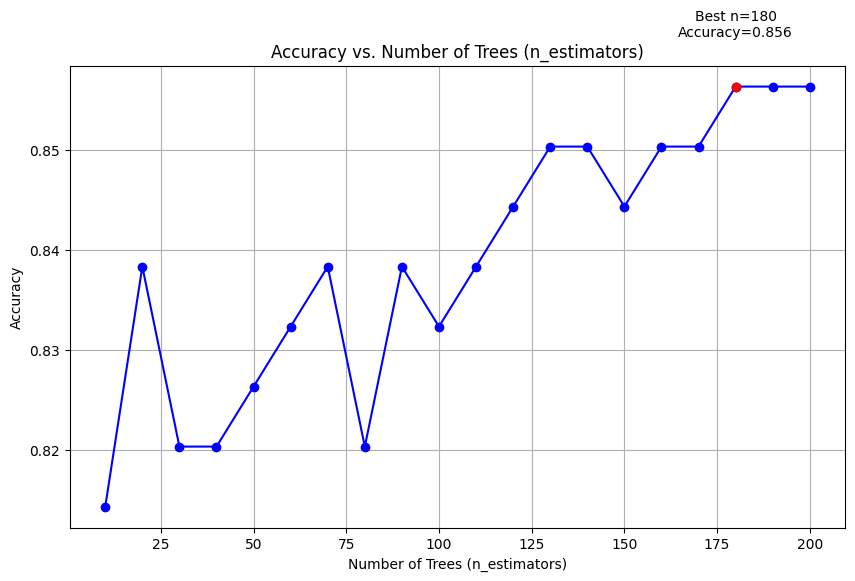

In [108]:
import matplotlib.pyplot as plt

# 数据
n_estimators = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
    110, 120, 130, 140, 150, 160, 170, 180, 190, 200
]
accuracies = [
    0.8143712574850299, 0.8383233532934131, 0.8203592814371258, 0.8203592814371258, 
    0.8263473053892215, 0.8323353293413174, 0.8383233532934131, 0.8203592814371258, 
    0.8383233532934131, 0.8323353293413174, 0.8383233532934131, 0.844311377245509, 
    0.8502994011976048, 0.8502994011976048, 0.844311377245509, 0.8502994011976048, 
    0.8502994011976048, 0.8562874251497006, 0.8562874251497006, 0.8562874251497006
]

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracies, marker='o', linestyle='-', color='blue')

# 添加标题和标签
plt.title('Accuracy vs. Number of Trees (n_estimators)')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')

# 标记最优点
best_n = n_estimators[accuracies.index(max(accuracies))]
best_acc = max(accuracies)
plt.plot(best_n, best_acc, marker='o', color='red')
plt.text(best_n, best_acc + 0.005, f'Best n={best_n}\nAccuracy={best_acc:.3f}', ha='center', fontsize=10)

# 显示图表
plt.grid(True)
plt.show()

归类

In [109]:
df_task   # 所有任务点数据

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格
0,A0001,22.566142,113.980837,66.0,0,66.605203
1,A0002,22.686205,113.940525,65.5,0,67.486857
2,A0003,22.576512,113.957198,65.5,1,66.081525
3,A0004,22.564841,114.244571,75.0,0,65.580365
4,A0005,22.558888,113.950723,65.5,0,65.889314
...,...,...,...,...,...,...
830,A0831,23.044062,113.125784,65.5,0,66.086292
831,A0832,22.833262,113.280152,72.0,1,65.007432
832,A0833,22.814676,113.827731,85.0,1,65.000000
833,A0834,23.063674,113.771188,65.5,1,70.697085


In [110]:
df_new_task_except  # 排除东莞市的任务点数据

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,预测合理价格,会员因子分数,竞争因子分数,预测任务执行情况
0,A0001,22.566142,113.980837,66.0,0,74.310175,0.000000,0.321041,1
1,A0002,22.686205,113.940525,65.5,0,79.423768,0.259111,0.238261,0
2,A0003,22.576512,113.957198,65.5,1,71.272848,0.096090,0.120215,0
3,A0004,22.564841,114.244571,75.0,0,68.366117,0.000000,0.116073,0
4,A0005,22.558888,113.950723,65.5,0,70.158023,0.064608,0.113255,0
...,...,...,...,...,...,...,...,...,...
828,A0829,23.179030,112.876192,80.0,1,69.900102,0.000000,0.168969,1
829,A0830,23.123411,113.151775,85.0,1,65.176826,0.006097,0.000000,1
830,A0831,23.044062,113.125784,65.5,0,71.300491,0.081730,0.135528,1
831,A0832,22.833262,113.280152,72.0,1,65.043107,0.001486,0.000000,1


In [111]:
# 使用 '预测合理价格' 列的值覆盖 '任务标价' 列的值
df_new_task_except['任务标价'] = df_new_task_except['预测合理价格']

In [112]:
df_new_task_except['任务执行情况'] = df_new_task_except['预测任务执行情况']

In [113]:
df_new_task_except = df_new_task_except[['任务号码', '任务gps纬度', '任务gps经度', '任务标价', '任务执行情况']]

In [114]:
df_new_task_except

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况
0,A0001,22.566142,113.980837,74.310175,1
1,A0002,22.686205,113.940525,79.423768,0
2,A0003,22.576512,113.957198,71.272848,0
3,A0004,22.564841,114.244571,68.366117,0
4,A0005,22.558888,113.950723,70.158023,0
...,...,...,...,...,...
828,A0829,23.179030,112.876192,69.900102,1
829,A0830,23.123411,113.151775,65.176826,1
830,A0831,23.044062,113.125784,71.300491,1
831,A0832,22.833262,113.280152,65.043107,1


更新任务标价

In [115]:
# 删除任务标价列
df_task = df_task.drop(columns=['任务标价'])
# 将“预测合理价格”列重命名为“任务标价”
df_task = df_task.rename(columns={'预测合理价格': '任务标价'})

In [116]:
df_task.iloc[eccept_index]

,任务号码,任务gps纬度,任务gps经度,任务执行情况,任务标价
372,A0373,23.097051,113.658152,1,67.149492
482,A0483,23.044908,113.788434,1,66.505060
485,A0486,22.777591,113.751681,1,65.396385
486,A0487,22.721038,114.179052,1,65.043406
487,A0488,22.812305,114.172988,1,65.000000
...,...,...,...,...,...
806,A0807,23.039098,113.773178,1,65.611801
807,A0808,22.846704,114.159286,1,65.544384
827,A0828,23.012808,113.760312,1,68.158712
832,A0833,22.814676,113.827731,1,65.000000


In [117]:
# 使用 pd.concat 将 除去东莞市的三市数据、东莞市数据，这两个 DataFrame 上下拼接
df_combined = pd.concat([df_new_task_except, df_task.iloc[eccept_index]])

# 重置索引以确保索引唯一并连续
df_combined.reset_index(drop=True, inplace=True)

# 查看合并后的 DataFrame
df_combined

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况
0,A0001,22.566142,113.980837,74.310175,1
1,A0002,22.686205,113.940525,79.423768,0
2,A0003,22.576512,113.957198,71.272848,0
3,A0004,22.564841,114.244571,68.366117,0
4,A0005,22.558888,113.950723,70.158023,0
...,...,...,...,...,...
830,A0807,23.039098,113.773178,65.611801,1
831,A0808,22.846704,114.159286,65.544384,1
832,A0828,23.012808,113.760312,68.158712,1
833,A0833,22.814676,113.827731,65.000000,1


In [118]:
df_combined['任务标价'].mean()

73.58571649242556

In [119]:
df_combined['任务执行情况'].sum()

575

In [120]:
df_combined.to_excel('../data/combined_tasks.xlsx', index=False)